<a href="https://colab.research.google.com/github/TrickyTroll/ML-intro/blob/Tricky/OCR_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Maintenant que le modèle est fait, voici quelques tests

## Prise de photo

In [128]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


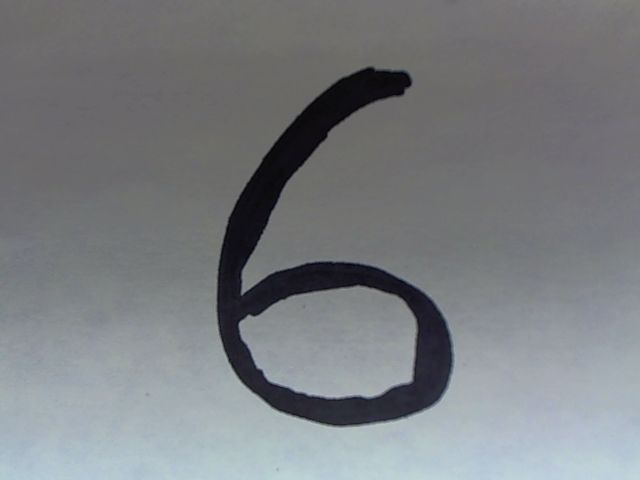

In [129]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

## Chargement du modèle

In [130]:
from tensorflow.keras.models import load_model

In [131]:
# load the numbers handwriting OCR model
print("[INFO] loading handwriting OCR model...")
model = load_model("/content/drive/My Drive/OCR_Models/test")

[INFO] loading handwriting OCR model...


## Préparation de l'image

In [132]:
from imutils.contours import sort_contours
from tensorflow.keras.datasets import mnist
import tensorflow as tf
from tensorflow import keras
import numpy as np
import argparse
import imutils
import cv2
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
((train_data, train_labels), (test_data, test_labels)) = mnist.load_data()

In [133]:
image = cv2.imread("photo.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
(thresh, blackAndWhiteImage) = cv2.threshold(gray, 95, 255, cv2.THRESH_BINARY)
resized_image = cv2.resize(blackAndWhiteImage, (28, 28))
cv2_imshow(resized_image)

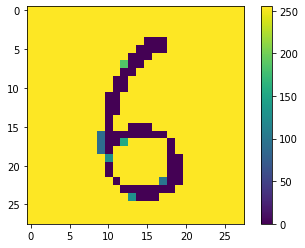

In [134]:
plt.figure()
plt.imshow(resized_image)
plt.colorbar()
plt.grid(False)
plt.show()

## Testing the model

In [145]:
img = (np.expand_dims(resized_image,0))

print(img.shape)

(1, 28, 28)


In [146]:
predictions_array = probability_model.predict(img)

print(predictions_array)

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


In [150]:
np.argmax(predictions_array[0])

7

In [151]:
def plot_single(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)


In [152]:
type(resized_image)
predicted_label = np.argmax(predictions_array)
predicted_label

7

## Stuff for later

In [153]:
# i = 0
# plt.figure(figsize=(6,3))
# plt.subplot(1,2,1)
# plot_image(i, predictions_single[i], test_labels, resized_image)
# plt.subplot(1,2,2)
# plot_value_array(i, predictions_single[i],  test_labels)
# plt.show()

In [142]:
# edged = cv2.Canny(blurred, 30, 150)
# cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
# 	cv2.CHAIN_APPROX_SIMPLE)
# cnts = imutils.grab_contours(cnts)
# cnts = sort_contours(cnts, method="left-to-right")[0]
# chars = []
# for c in cnts:
# 	# compute the bounding box of the contour
# 	(x, y, w, h) = cv2.boundingRect(c)
# 	# filter out bounding boxes, ensuring they are neither too small
# 	# nor too large
# 	if (w >= 5 and w <= 150) and (h >= 15 and h <= 120):
# 		# extract the character and threshold it to make the character
# 		# appear as *white* (foreground) on a *black* background, then
# 		# grab the width and height of the thresholded image
# 		roi = gray[y:y + h, x:x + w]
# 		thresh = cv2.threshold(roi, 0, 255,
# 			cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
# 		(tH, tW) = thresh.shape
# 		# if the width is greater than the height, resize along the
# 		# width dimension
# 		if tW > tH:
# 			thresh = imutils.resize(thresh, width=32)
# 		# otherwise, resize along the height
# 		else:
# 			thresh = imutils.resize(thresh, height=32)
#    		# re-grab the image dimensions (now that its been resized)
# 		# and then determine how much we need to pad the width and
# 		# height such that our image will be 32x32
# 		(tH, tW) = thresh.shape
# 		dX = int(max(0, 32 - tW) / 2.0)
# 		dY = int(max(0, 32 - tH) / 2.0)
# 		# pad the image and force 32x32 dimensions
# 		padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
# 			left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
# 			value=(0, 0, 0))
# 		padded = cv2.resize(padded, (32, 32))
# 		# prepare the padded image for classification via our
# 		# handwriting OCR model
# 		padded = padded.astype("float32") / 255.0
# 		padded = np.expand_dims(padded, axis=-1)
# 		# update our list of characters that will be OCR'd
# 		chars.append((padded, (x, y, w, h)))

In [143]:
# # extract the bounding box locations and padded characters
# boxes = [b[1] for b in chars]
# chars = np.array([c[0] for c in chars], dtype="float32")
# boxes
# # OCR the characters using our handwriting recognition model
# # probability_model = tf.keras.Sequential([model, 
# #                                          tf.keras.layers.Softmax()])
# # preds = probability_model.predict(boxes)
# # # define the list of label names
# # labelNames = "0123456789"
# # labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
# # labelNames = [l for l in labelNames]

In [144]:
# # loop over the predictions and bounding box locations together
# for (pred, (x, y, w, h)) in zip(preds, boxes):
# 	# find the index of the label with the largest corresponding
# 	# probability, then extract the probability and label
# 	i = np.argmax(pred)
# 	prob = pred[i]
# 	label = labelNames[i]
# 	# draw the prediction on the image
# 	print("[INFO] {} - {:.2f}%".format(label, prob * 100))
# 	cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
# 	cv2.putText(image, label, (x - 10, y - 10),
# 		cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)
# 	# show the image
# 	cv2.imshow("Image", image)
# 	cv2.waitKey(0)